In [1]:
# importação do pandas para trabalhar com calcúlos no modelo
import numpy as np

# importação do pandas para realizar a analisse dos dados
import pandas as pd

from IPython.display import display

# biblioteca do panda com o objetivo de ler CSV´s
from pandas import read_csv
from pandas.core import datetools

# bilioteca do para manpulação de variaveis de hora
import datetime

# bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.pylab import rcParams

import warnings
import itertools

# gráficos gerados sejam mostrados no notebook e não em uma nova janela
%matplotlib inline

# importação da bilioteca relativedelt para trabalhar com mamipulação de datas
from dateutil.relativedelta import relativedelta

# importação da função para trabalhar com o statsmodels no modelo de time series forecasting
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from subprocess import check_output

C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  # This is added back by InteractiveShellApp.init_path()


In [2]:
# ler os dados do dadaset e definir o formato das colunas
data = pd.read_csv("license_plates_acution_data.csv",usecols=["Date", "num_bidder", "num_plates", "lowest_deal_price", 
                 "avg_deal_price"], dtype={"Date":"str", "num_bidder":"float", "num_plates":"float", 
                 "lowest_deal_price":"float", "avg_deal_price":"float"})
data.head()

,Date,avg_deal_price,lowest_deal_price,num_bidder,num_plates
0,2002.1,14735.0,13600.0,3718.0,1400.0
1,2002.2,14057.0,13100.0,4590.0,1800.0
2,2002.3,14662.0,14300.0,5190.0,2000.0
3,2002.4,16334.0,16000.0,4806.0,2300.0
4,2002.5,18357.0,17800.0,4665.0,2350.0


In [3]:
# converter coluna date para uma coluna datetime
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date",inplace=True)
data.head()

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
Date,,,,
2002-01-01,14735.0,13600.0,3718.0,1400.0
2002-02-01,14057.0,13100.0,4590.0,1800.0
2002-03-01,14662.0,14300.0,5190.0,2000.0
2002-04-01,16334.0,16000.0,4806.0,2300.0
2002-05-01,18357.0,17800.0,4665.0,2350.0


In [4]:
# checando valores faltantes no dataset
for y in range(2002,2018):
    print(y,": ", data[str(y)].shape)

2002 :  (12, 4)
2003 :  (12, 4)
2004 :  (12, 4)
2005 :  (12, 4)
2006 :  (12, 4)
2007 :  (12, 4)
2008 :  (11, 4)
2009 :  (12, 4)
2010 :  (12, 4)
2011 :  (12, 4)
2012 :  (12, 4)
2013 :  (12, 4)
2014 :  (12, 4)
2015 :  (12, 4)
2016 :  (12, 4)
2017 :  (10, 4)


In [5]:
# cavar em 2008, faltam fevereiro, preencher a linha perdida com a média de cada coluna
feb_2008 = pd.DataFrame([data["2008"].mean(axis=0)],index=[pd.to_datetime("2008-02-01")],columns=data.columns)
data = pd.concat([data,feb_2008])
data.sort_index(inplace=True)

In [6]:
data["2008"]

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
2008-01-01,23370.000000,8100.000000,20539.000000,16000.000000
2008-02-01,32379.181818,29945.454545,22616.636364,7681.818182
2008-03-01,32169.000000,31300.000000,63534.000000,9300.000000
2008-04-01,37659.000000,37300.000000,37072.000000,9000.000000
2008-05-01,36047.000000,34400.000000,26341.000000,8200.000000
2008-06-01,34947.000000,33900.000000,21208.000000,7700.000000
2008-07-01,34491.000000,33800.000000,16783.000000,6800.000000
2008-08-01,36460.000000,35900.000000,13451.000000,6000.000000
2008-09-01,31788.000000,29300.000000,11002.000000,6500.000000
2008-10-01,33224.000000,32600.000000,11882.000000,5000.000000


Text(0.5,1,'Lowest Deal Price')

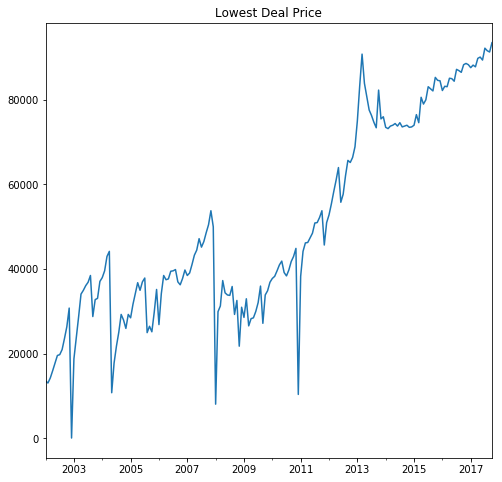

In [7]:
plt.figure(figsize=(8,8))
data["lowest_deal_price"].plot()
plt.title("Lowest Deal Price")

In [8]:
# claramente há uma tendência a subir, mas também existem alguns valores atípicos em torno de 2003,2008,2001. 
# os outliers provavelmente foram causados por interferência governamental ou mudança de política, o que é incomum vamos lidar com estes mercados, substituindo esses valores por meio do respectivo ano

data.set_value("2002-12-01","lowest_deal_price",data["2002"]["lowest_deal_price"].mean(axis=0))
data.set_value("2008-01-01","lowest_deal_price",data["2007-02":"2008-02"]["lowest_deal_price"].mean(axis=0))
data.set_value("2010-12-01","lowest_deal_price",data["2010"]["lowest_deal_price"].mean(axis=0))

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
2002-01-01,14735.0,13600.000000,3718.0,1400.0
2002-02-01,14057.0,13100.000000,4590.0,1800.0
2002-03-01,14662.0,14300.000000,5190.0,2000.0
2002-04-01,16334.0,16000.000000,4806.0,2300.0
2002-05-01,18357.0,17800.000000,4665.0,2350.0
2002-06-01,20178.0,19600.000000,4502.0,2800.0
2002-07-01,20904.0,19800.000000,3774.0,3000.0
2002-08-01,21601.0,21000.000000,4640.0,3000.0
2002-09-01,24040.0,23600.000000,4393.0,3200.0
2002-10-01,27040.0,26400.000000,4661.0,3200.0


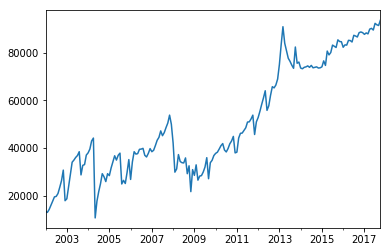

In [9]:
# visualizar o modelo que agora está um pouco mais suave
data["lowest_deal_price"].plot()

In [10]:
#  Construir uma função para testar a serie estacionaria
def test_stationary(ts_data):
    ## visually check
    rol_mean = pd.rolling_mean(ts_data,window=12)
    rol_std = pd.rolling_std(ts_data,window=12)
    
    plt.figure(figsize=(6,6))
    plt.plot(ts_data,label='original')
    plt.plot(rol_mean,label="rolling mean")
    plt.plot(rol_std,label="rolling std")
    plt.legend()
    
    ## adfuller test
    result = adfuller(ts_data,autolag="AIC")
    print("---"*5,"ADF TEST RESULT","---"*5,"\n")
    print(" ADF value: ",result[0])
    print(" P_Value: ",result[1])
    print(" Lags used: ", result[2])
    print(" num of obs: ", result[3])
    print("intervals: ", result[4])

--------------- ADF TEST RESULT --------------- 

 ADF value:  -0.979029182671
 P_Value:  0.760835881278
 Lags used:  1
 num of obs:  188
intervals:  {'1%': -3.4656203971241921, '5%': -2.8770397560752436, '10%': -2.5750324547306476}


C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


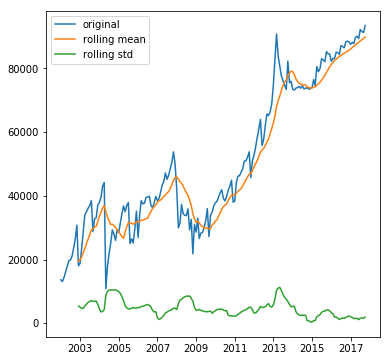

In [11]:
# verificação de estatística dos dados originais
# do resultado (p_value), podemos ver que as séries temporais originais não são estacionárias

test_stationary(data["lowest_deal_price"])

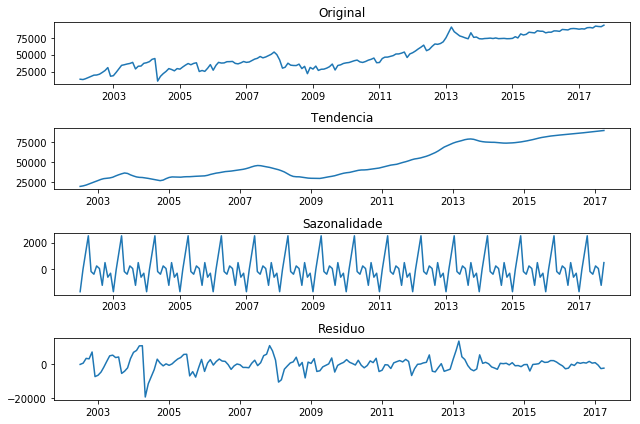

In [12]:
# decompor a tendência, os componentes sazonais dos dados
decomposition = seasonal_decompose(data["lowest_deal_price"])
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(9,6))
plt.subplot(411)
plt.plot(data["lowest_deal_price"])
plt.title("Original")
plt.subplot(412)
plt.plot(trend)
plt.title("Tendencia")
plt.subplot(413)
plt.plot(seasonal)
plt.title("Sazonalidade")
plt.subplot(414)
plt.plot(residual)
plt.title("Residuo")
plt.tight_layout()

--------------- ADF TEST RESULT --------------- 

 ADF value:  -9.17670320351
 P_Value:  2.30976016153e-15
 Lags used:  3
 num of obs:  174
intervals:  {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.5757041590698901}


C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


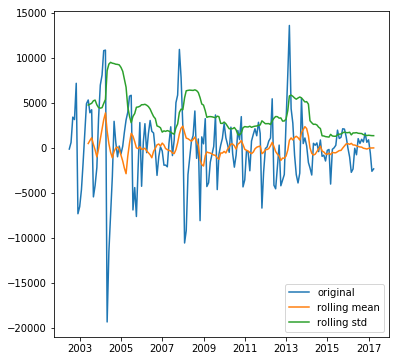

In [13]:
# Verificar a capacidade estacionaria dos residuos
test_stationary(residual.dropna())

--------------- ADF TEST RESULT --------------- 

 ADF value:  -1.4364628517
 P_Value:  0.564675988593
 Lags used:  7
 num of obs:  182
intervals:  {'1%': -3.4668001583460613, '5%': -2.8775552336674317, '10%': -2.5753075498128246}


C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


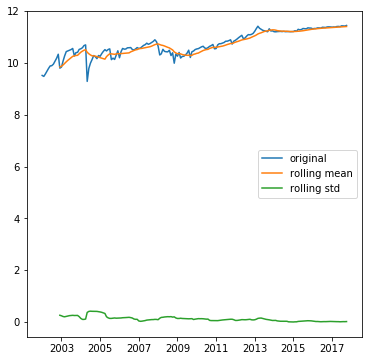

In [14]:
# Estacionar manualmente, isso geralmente pode ser feito por transformação de log ou diferença
data_log = np.log(data["lowest_deal_price"])
test_stationary(data_log)

--------------- ADF TEST RESULT --------------- 

 ADF value:  -9.96284104619
 P_Value:  2.34869316457e-17
 Lags used:  2
 num of obs:  186
intervals:  {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}


C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


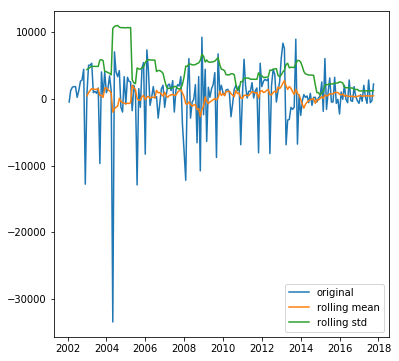

In [15]:
# Usar função diff () para fazer a diferença
data_diff_1 = data["lowest_deal_price"].diff().dropna()
test_stationary(data_diff_1)

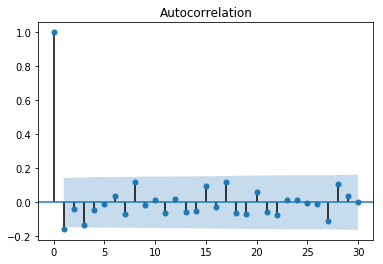

In [16]:
# a série temporal está estacionária agora, vou traçar o acf e o pacf para a seleção do modelo
acf_plot = plot_acf(data_diff_1,lags=30)

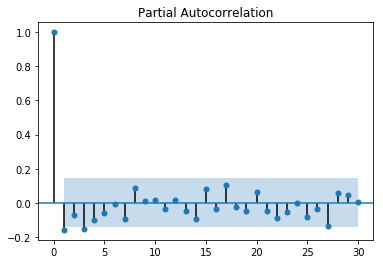

In [17]:
# a série temporal está estacionária agora, vou traçar o acf e o pacf para a seleção do modelo
pacf_plot = plot_pacf(data_diff_1,lags=30)

In [18]:
model = ARIMA(data["lowest_deal_price"],order=(2,1,1))
model_fit = model.fit(disp=1)
summary = model_fit.summary()
fitted_values = model_fit.fittedvalues
print(summary)

                              ARIMA Model Results                              
Dep. Variable:     D.lowest_deal_price   No. Observations:                  189
Model:                  ARIMA(2, 1, 1)   Log Likelihood               -1848.708
Method:                        css-mle   S.D. of innovations           4282.164
Date:                 Thu, 08 Mar 2018   AIC                           3707.416
Time:                         22:38:12   BIC                           3723.625
Sample:                     02-01-2002   HQIC                          3713.982
                          - 10-01-2017                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       413.2338    166.791      2.478      0.014      86.330     740.138
ar.L1.D.lowest_deal_price     0.5687      0.177      3.213      0.002       0.

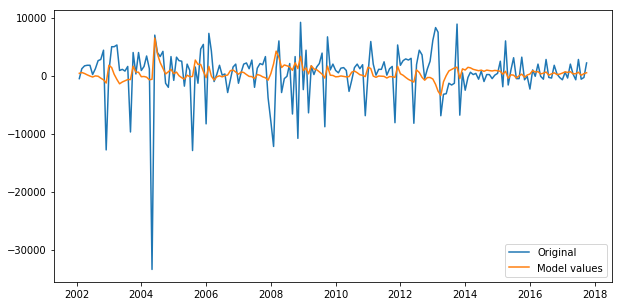

In [19]:
plt.figure(figsize=(10,5))
plt.plot(data_diff_1,label="Original")
plt.plot(fitted_values, label="Model values")
plt.legend()